In [21]:
import pandas as pd
import seaborn as sns 
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.stats import sem

%matplotlib inline
%config Completer.use_jedi = False


#import required sklearn for logistic regression classifier

import sklearn as sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix,roc_auc_score, f1_score
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold, RepeatedKFold, cross_validate
from sklearn.feature_selection import mutual_info_classif,VarianceThreshold, SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [22]:
#Load the filtered isoform switch file and the file containing all genes for COAD
#Only matched samples / files used

isoform_switch_file = '/Users/jake/OneDrive - University of Glasgow/Project/COAD/Survival/COAD_isoform_survival.csv'
all_genes_file = '/Users/jake/OneDrive - University of Glasgow/Project/COAD/Survival/COAD_all_genes_survival.csv'

isoform_survival = pd.read_csv(isoform_switch_file,header=[0,1],sep='\t',index_col=[0])
all_genes_survival = pd.read_csv(all_genes_file,header=[0,1],sep='\t',index_col=[0])


In [23]:
isoform_survival

Gene_symbol,CTTN,FBLN2,FLNA,ARHGEF9,SLC39A14,ATP6V1C2,ISLR,MYH11,SRI,UGP2,IL1R2,HKDC1,CD44,400_days_status
Gene_ensembl_id,ENSG00000085733,ENSG00000163520,ENSG00000196924,ENSG00000131089,ENSG00000104635,ENSG00000143882,ENSG00000129009,ENSG00000133392,ENSG00000075142,ENSG00000169764,ENSG00000115590,ENSG00000156510,ENSG00000026508,400_days_status
TCGA-AA-A03F,70.448546,3.228069,34.402131,2.707335,12.901203,0.851872,8.693111,3.769247,15.084670,6.701474,2.869665,31.742125,22.468272,1
TCGA-DM-A28A,39.091459,8.280069,75.628166,3.926473,19.024760,1.724790,46.326536,2.648630,21.757126,15.647466,0.832169,30.443059,28.148785,1
TCGA-AA-3848,34.643505,6.704867,80.819438,3.562803,9.424352,4.562801,24.984541,2.263682,22.779253,2.642957,1.794723,43.801608,40.018936,0
TCGA-F4-6459,36.564046,13.846183,218.687580,2.453711,18.270521,4.470305,50.994662,137.275257,30.454773,21.198196,2.637511,36.133464,20.707839,0
TCGA-A6-2686,20.172616,11.047990,39.440702,2.686910,29.445689,1.358366,26.509775,4.201186,93.478642,12.939356,3.460002,4.743835,66.239432,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-DM-A288,37.044200,1.124790,13.640565,2.476778,23.683983,0.943946,8.692924,1.652329,28.165274,14.589347,0.944468,18.804690,40.290810,1
TCGA-AA-A02E,55.497694,2.418053,39.568716,3.180025,19.204434,1.305272,10.798450,1.481463,32.989371,16.419382,0.721987,26.637190,26.080903,0
TCGA-AZ-4614,38.159885,1.258865,11.407843,4.049046,14.718795,1.339645,3.078987,1.038900,28.963359,12.705245,7.049513,13.761649,34.241215,0


In [24]:
#Check isoform_switch for and missing data

isoform_survival.isnull().sum().unique()

array([0])

In [25]:
#Check all genes file for missing data

all_genes_survival.isnull().sum().sort_values(ascending = False)
all_genes_survival.isnull().sum().unique()


array([0])

In [26]:
#Check survival ratio ... since almost equal will not use 'class_weight' in model

survival_ratio = sum(isoform_survival['400_days_status','400_days_status']==1) / sum(isoform_survival['400_days_status','400_days_status']==0)
survival_ratio

1.06

In [27]:
#Do an initial train test split to extract an 'unseen' test set of data (30%) for both isoform and all genes
#Set stratify as y to keep same ratio in test data

X_full_iso = isoform_survival.drop('400_days_status',axis=1,level=0)
y_full_iso = isoform_survival['400_days_status','400_days_status']

X_develop_iso, X_test_iso, y_develop_iso, y_test_iso = train_test_split(X_full_iso, y_full_iso, test_size=0.3, random_state=1,stratify=y_full_iso)


In [28]:
#Repeat for all genes .. using random sample of same number of genes as isoform

X_full_all = all_genes_survival.drop('400_days_status',axis=1,level=0)
y_full_all = all_genes_survival['400_days_status','400_days_status']

#Take a random sample of genes .. use X_full_iso.columns to acquire same num of genes as isoform
X_random = X_full_all.sample(n=len(X_full_iso.columns),axis=1)

X_develop_ran, X_test_ran, y_develop_ran, y_test_ran = train_test_split(X_random, y_full_all, test_size=0.3, random_state=1,stratify=y_full_all)


In [29]:
#First do simple Logistic Regression with gridsearch to determine optimal parameters

def grid_search_LR(X,y):
    '''Perform logistic regression grid search. Supply development X and y data.'''

    #Logistic Regression with dual = False since n_samples > n_features
    classifier = LogisticRegression(dual=False)
    
    #Want to add PCA to pipeline
    pca = PCA()

    #Pipeline containing Log Reg classifier and Log Reg with deafault settings for feature engineering
    #Also added scaler as error related to iterations / convergance appears, which can be due to 'poor scaling'
    LR_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                                  ('pca',pca),
                                  ('feature_selection', SelectFromModel(LogisticRegression(dual=False))),
                                  ('classifier',classifier)])


    #Two dictionaries of potential potential parameters to account for penalties and solvers that can/can't go togther
    #The PCA searches from 1 upto max number of features / genes in 5 steps (since can't search PC's more than max num of features)
    param_grid = [
        {'classifier__penalty': ['l1'], 'classifier__solver': ['liblinear', 'saga'],
         'classifier__C':[0.01,0.1,1,10,100], 'pca__n_components': [x for x in range(1,int(len(X_full_iso.columns)),int(len(X_full_iso.columns)/5))]},
        {'classifier__penalty': ['l2'], 'classifier__solver': ['liblinear', 'sag', 'saga','newton-cg'],
         'classifier__C':[0.01,0.1,1,10,100],'pca__n_components':[x for x in range(1,int(len(X_full_iso.columns)),int(len(X_full_iso.columns)/5))] }
    ]


    #Use repeated stratified k fold to maintian ratio between tumor and normal and do multliple splits of data
    r_stratkfold = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=0)

    grid_search = GridSearchCV(LR_pipeline, param_grid=param_grid, scoring="roc_auc",cv=r_stratkfold)

    #Fit on development data
    grid_search.fit(X, y)
    
    #Create dictinoary to store the best parameters
    best_params = {}
    
    for k,v in grid_search.best_params_.items():
        
        best_params[k] = v
 
    #Return the best_params dictinoary => run this fuction and save as new variable in relation to what X and y run
    return best_params

In [30]:
#Run the gridsearch for both the isoform and all genes development data to create dictionaries to plug into CV

best_params_iso = grid_search_LR(X_develop_iso,y_develop_iso)
best_params_iso

/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'classifier__C': 1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear',
 'pca__n_components': 3}

In [31]:
best_params_ran = grid_search_LR(X_develop_ran,y_develop_ran)
best_params_ran

/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarni

/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarni

/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarni

/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarni

{'classifier__C': 1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear',
 'pca__n_components': 1}

In [32]:
#Now define model functions that will return cross_validate to evalaute model overall

In [33]:
# Create a function that cross validates the data

def LR_model_cv(X, y, best_params_dict, repeats = 3, splits = 3):
    '''LR model function. Takes in X and y development data, repeats, splits and the required best_params dictinoary'''

    #First perform RepeatedStratifiedKFold
    r_stratkfold = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats)
    
    # Create classifier with LR model using best_params_iso from gridsearch
    
    classifier = LogisticRegression(C=best_params_dict['classifier__C'],
                                   penalty= best_params_dict['classifier__penalty'],
                                   solver = best_params_dict['classifier__solver'], 
                                   random_state=1,
                                   dual = False)
    
    #Create pipleine with scaling, feature selection (set as classifier to add best parameters) and the classifier
    LR_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                                  ('pca',PCA(n_components=best_params_dict['pca__n_components'])),
                                   ('feature_selection', SelectFromModel(classifier,threshold='mean')),
                                   ('classifier',classifier)])
    
    
    # evaluate the cross_validate
    scores_cv = cross_validate(LR_pipeline, X, y, cv=r_stratkfold,
                            scoring=('f1_weighted','roc_auc','balanced_accuracy','precision_weighted','recall_weighted'))
    
    #Define performance metrics to return 
    F1 = str(f"Mean F1 weighted = {scores_cv['test_f1_weighted'].mean():.3f} SEM = {sem(scores_cv['test_f1_weighted']):.3f}")
    ROCAUC = str(f"Mean ROCAUC score = {scores_cv['test_roc_auc'].mean():.3f} SEM = {sem(scores_cv['test_roc_auc']):.3f} ")
    Accuracy = str(f"Mean balanced accuracy score = {scores_cv['test_balanced_accuracy'].mean():.3f} SEM = {sem(scores_cv['test_balanced_accuracy']):.3f} ")
    Precision = str(f"Mean weighted precision = {scores_cv['test_precision_weighted'].mean():.3f} SEM = {sem(scores_cv['test_precision_weighted']):.3f} ")
    Recall = str(f"Mean weighted recall = {scores_cv['test_recall_weighted'].mean():.3f} SEM = {sem(scores_cv['test_recall_weighted']):.3f} ")
    
    return F1, ROCAUC, Accuracy, Precision, Recall

In [34]:
#Compare the two cross validations with 3 repeats and 3 splits

LR_model_cv(X_develop_iso,y_develop_iso,best_params_iso)

('Mean F1 weighted = 0.538 SEM = 0.025',
 'Mean ROCAUC score = 0.555 SEM = 0.037 ',
 'Mean balanced accuracy score = 0.541 SEM = 0.026 ',
 'Mean weighted precision = 0.543 SEM = 0.026 ',
 'Mean weighted recall = 0.542 SEM = 0.025 ')

In [35]:
LR_model_cv(X_develop_ran,y_develop_ran,best_params_ran)

('Mean F1 weighted = 0.515 SEM = 0.024',
 'Mean ROCAUC score = 0.515 SEM = 0.019 ',
 'Mean balanced accuracy score = 0.526 SEM = 0.024 ',
 'Mean weighted precision = 0.530 SEM = 0.026 ',
 'Mean weighted recall = 0.523 SEM = 0.023 ')

In [36]:
#Now create models utilising the above parameters to perform a test on the unseeen test data

In [37]:
# Create function to perform test

def LR_model_test(X_develop,y_develop,X_test,y_test, best_params_dict):
    '''Function fits the predetermined LR_pipeline for the data before predicting on the unseen test data'''
    
    classifier = LogisticRegression(C=best_params_dict['classifier__C'],
                                   penalty= best_params_dict['classifier__penalty'],
                                   solver = best_params_dict['classifier__solver'], 
                                   random_state=1,
                                   dual = False)
    
    LR_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                                  ('pca',PCA(n_components=best_params_dict['pca__n_components'])),
                                   ('feature_selection', SelectFromModel(classifier,threshold='mean')),
                                   ('classifier',classifier)])
    
    #Fit on the develop data
    LR_pipeline.fit(X_develop,y_develop)
    
    #Then make predictions on the unseen test data from the initial train test split
    predictions = LR_pipeline.predict(X_test)
    
    #Return classification report and ROCAUC score
    print (classification_report(predictions,y_test,target_names=['Desceased Before - 0','Deceased After - 1']))
    ROCAUC =  str(f'ROCAUC score: {roc_auc_score(predictions,y_test):.3f}')
    
    return ROCAUC

In [38]:
#Now run on both set of data to compare the results

In [39]:
LR_model_test(X_develop_iso,y_develop_iso,X_test_iso,y_test_iso,best_params_iso)

              precision    recall  f1-score   support

  Normal - 0       0.27      0.33      0.30        12
  Cancer - 1       0.50      0.42      0.46        19

    accuracy                           0.39        31
   macro avg       0.38      0.38      0.38        31
weighted avg       0.41      0.39      0.39        31



'ROCAUC score: 0.377'

In [40]:
LR_model_test(X_develop_ran,y_develop_ran,X_test_ran,y_test_ran,best_params_ran)

              precision    recall  f1-score   support

  Normal - 0       0.53      0.47      0.50        17
  Cancer - 1       0.44      0.50      0.47        14

    accuracy                           0.48        31
   macro avg       0.49      0.49      0.48        31
weighted avg       0.49      0.48      0.48        31



'ROCAUC score: 0.485'

In [41]:
#Additional functions for extra plots below

In [42]:
#Create function to extract the PCA explained variance function and make plot

def grid_search_PCA(X,y,best_params_dict):
    '''Perform logistic regression grid search. Supply development X and y data.'''

    #Logistic Regression with dual = False since n_samples > n_features
    classifier = LogisticRegression(C=best_params_dict['classifier__C'],
                                   penalty= best_params_dict['classifier__penalty'],
                                   solver = best_params_dict['classifier__solver'], 
                                   random_state=1,
                                   dual = False)
    
    #Want to add PCA to pipeline
    pca = PCA()

    #Pipeline containing Log Reg classifier and Log Reg with deafault settings for feature engineering
    #Also added scaler as error related to iterations / convergance appears, which can be due to 'poor scaling'
    LR_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                                  ('pca',pca),
                                  ('feature_selection', SelectFromModel(classifier)),
                                  ('classifier',classifier)])


    
    #The PCA searches from 1 upto max number of features / genes in 5 steps (since can't search PC's more than max num of features)
    param_grid = {'pca__n_components':[x for x in range(1,int(len(X_full_iso.columns)),int(len(X_full_iso.columns)/5))] }



    #Use repeated stratified k fold to maintian ratio between tumor and normal and do multliple splits of data
    r_stratkfold = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=0)

    grid_search = GridSearchCV(LR_pipeline, param_grid=param_grid, scoring="roc_auc",cv=r_stratkfold)

    #Fit on development data
    grid_search.fit(X, y)
    
    #Now to plot the PCA variance ratio
    
    # first Fit the PCA to X
    pca.fit(X)
    
 
    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))
    ax0.plot(np.arange(1, pca.n_components_ + 1),
             pca.explained_variance_ratio_, linewidth=2)
    ax0.set_ylabel('PCA explained variance ratio')

    ax0.axvline(grid_search.best_estimator_.named_steps['pca'].n_components,
                linestyle=':', label='n_components chosen')
    ax0.legend(prop=dict(size=8))

    # For each number of components, find the best classifier results
    results = pd.DataFrame(grid_search.cv_results_)
    components_col = 'param_pca__n_components'
    best_clfs = results.groupby(components_col).apply(
        lambda g: g.nlargest(1, 'mean_test_score'))

    best_clfs.plot(x=components_col, y='mean_test_score',
                   legend=False, ax=ax1)
    ax1.set_ylabel('ROCAUC Score')
    ax1.set_xlabel('n_components')

    plt.xlim(-1, len(X_full_iso.columns)+2)

    plt.tight_layout()  
    
    return fig

/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_base.py:92: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)
/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jake/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1346, in fit
    accept_large_sparse=solver != 'liblinear')
  File "/Users/jake/

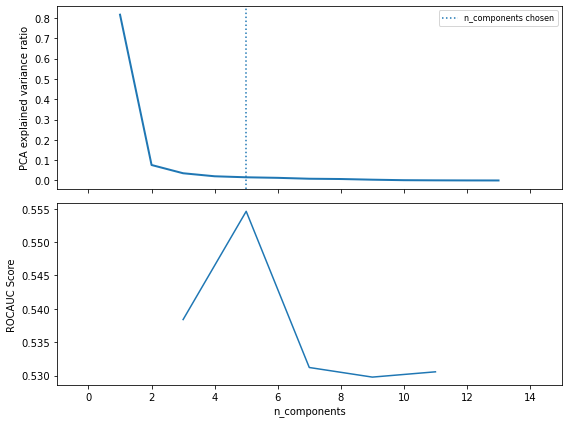

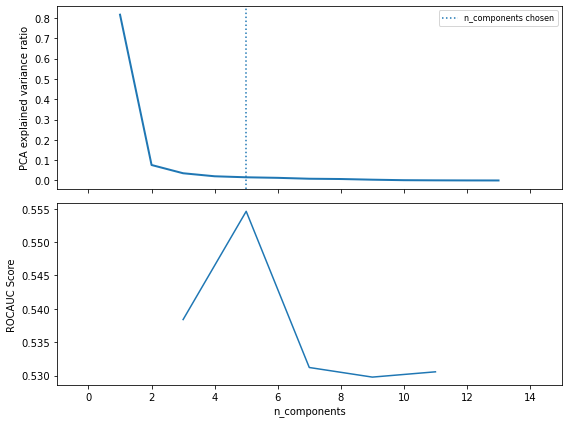

In [43]:
grid_search_PCA(X_develop_iso,y_develop_iso,best_params_iso)

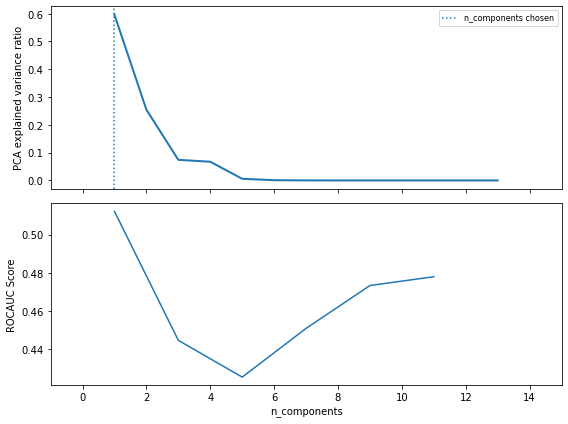

In [44]:
PCA_plot_ran = grid_search_PCA(X_develop_ran,y_develop_ran,best_params_ran)

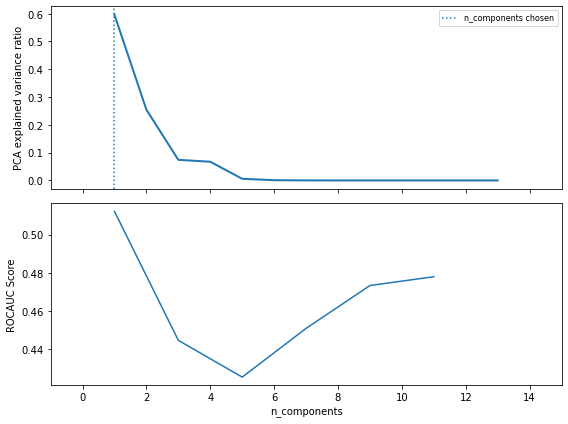

In [45]:
PCA_plot_ran

In [46]:
#Def function to extract the features selected during pipeline SelectFromModel as a list 

def LR_model_features(X, y, best_params_dict, repeats = 3, splits = 3):
    '''LR model function. Takes in X and y development data, repeats, splits, the required best_params dictinoary and the max_features to return from SelectFromModel'''

    #First perform RepeatedStratifiedKFold
    r_stratkfold = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats)
    
    # Create classifier with LR model using best_params_iso from gridsearch
    
    classifier = LogisticRegression(C=best_params_dict['classifier__C'],
                                   penalty= best_params_dict['classifier__penalty'],
                                   solver = best_params_dict['classifier__solver'], 
                                   random_state=1,
                                   dual = False)
    
    #Create pipleine with scaling, feature selection (set as classifier to add best parameters) and the classifier
    LR_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                                  ('pca',PCA(n_components=best_params_dict['pca__n_components'])),
                                   ('feature_selection', SelectFromModel(classifier,threshold='mean')),
                                   ('classifier',classifier)])
    
    
    # evaluate the cross_validate
    scores_cv = cross_validate(LR_pipeline, X, y, cv=r_stratkfold,
                            scoring=('f1_weighted','roc_auc','balanced_accuracy','precision_weighted','recall_weighted'))
    
    
    #To get the features selected via SelectFromModel need to fit the pipeline and extract the named_steps['feature_selection']
    selected_features = LR_pipeline.named_steps['feature_selection'].fit(X,y)
    
    #Can then plug selected_features.get_support into X.columns (which is full set of features)
    features = X.columns[selected_features.get_support()]
    
    return list(features)

In [47]:
LR_model_features(X_develop_iso,y_develop_iso,best_params_iso)


[('ATP6V1C2', 'ENSG00000143882'),
 ('UGP2', 'ENSG00000169764'),
 ('IL1R2', 'ENSG00000115590'),
 ('HKDC1', 'ENSG00000156510')]